In [1]:
from torch_geometric.data import InMemoryDataset, Data
import networkx as nx
import torch
import numpy as np
import community as community_louvain
from networkx import karate_club_graph, to_numpy_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import graph_nets as gn
from tensorflow.keras.utils import to_categorical
from graph_nets import utils_np,utils_tf,modules
import sonnet as snt
from torch_geometric.utils import to_networkx

In [2]:
class KarateClub(InMemoryDataset):

    def __init__(self, transform=None):
        super(KarateClub, self).__init__('.', transform, None, None)

        G = nx.karate_club_graph()

        x = torch.eye(G.number_of_nodes(), dtype=torch.float)
        order = sorted(list(G.nodes()))
        adjency = to_numpy_matrix(G,nodelist=order)
        
        adj = nx.to_scipy_sparse_matrix(G).tocoo()
        row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
        col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
        edge_index = torch.stack([row, col], dim=0)

        # Compute communities.
        partition = community_louvain.best_partition(G)
        y = torch.tensor([partition[i] for i in range(G.number_of_nodes())])
        senders = edge_index[0]
        receivers = edge_index[1]
        # Select a single training node for each community
        # (we just use the first one).
        train_mask = torch.zeros(y.size(0), dtype=torch.bool)
        number_of_nodes = G.number_of_nodes()
        for i in range(int(y.max()) + 1):
            train_mask[(y == i).nonzero(as_tuple=False)[0]] = True

        data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask,
                    adjency = adjency,number_of_nodes = number_of_nodes)

        self.data, self.slices = self.collate([data])

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [3]:
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

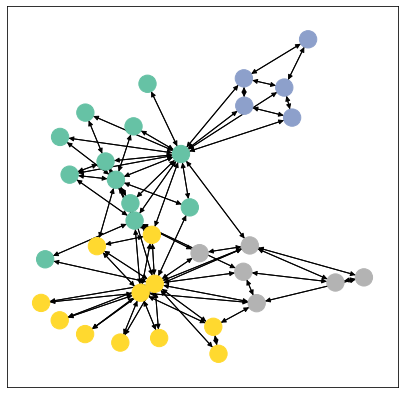

In [4]:
dataset_from_karate = KarateClub()
dataset_from_karate = dataset_from_karate[0]
G = to_networkx(dataset_from_karate)
G.number_of_nodes()
visualize(G, color=dataset_from_karate.y)

In [5]:
def print_graphs_tuple(graphs_tuple):
  print("\nData contained in `GraphsTuple`'s fields:")
  print("globals:\n{}".format(graphs_tuple.globals))
  print("nodes:\n{}".format(graphs_tuple.nodes))
  print("edges:\n{}".format(graphs_tuple.edges))
  print("senders:\n{}".format(graphs_tuple.senders))
  print("receivers:\n{}".format(graphs_tuple.receivers))
  print("n_node:\n{}".format(graphs_tuple.n_node))
  print("n_edge:\n{}".format(graphs_tuple.n_edge))


In [6]:
def plot_graphs_tuple_np(graphs_tuple):
  networkx_graphs = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
  num_graphs = len(networkx_graphs)
  _, axes = plt.subplots(1, num_graphs, figsize=(5*num_graphs, 5))
  if num_graphs == 1:
    axes = axes,
  for graph, ax in zip(networkx_graphs, axes):
    plot_graph_networkx(graph, ax)


def plot_graph_networkx(graph, ax, pos=None):
  node_labels = {node: "{:.3g}".format(data["features"][0])
                 for node, data in graph.nodes(data=True)
                 if data["features"] is not None}
  edge_labels = {(sender, receiver): "{:.3g}".format(data["features"][0])
                 for sender, receiver, data in graph.edges(data=True)
                 if data["features"] is not None}
  global_label = ("{:.3g}".format(graph.graph["features"][0])
                  if graph.graph["features"] is not None else None)

  if pos is None:
    pos = nx.spring_layout(graph)
  nx.draw_networkx(graph, pos, ax=ax, labels=node_labels)

  if edge_labels:
    nx.draw_networkx_edge_labels(graph, pos, edge_labels, ax=ax)

  if global_label:
    plt.text(0.05, 0.95, global_label, transform=ax.transAxes)

  ax.yaxis.set_visible(False)
  ax.xaxis.set_visible(False)
  return pos

[(0, 1), (2, 0), (3, 0)]

Data contained in `GraphsTuple`'s fields:
globals:
[[0]]
nodes:
[[0]
 [0]
 [0]
 [0]]
edges:
[[0]
 [0]
 [0]]
senders:
[0 2 3]
receivers:
[1 0 0]
n_node:
[4]
n_edge:
[3]


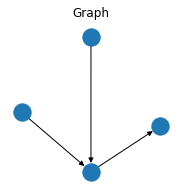

In [7]:
graph_nx = nx.OrderedDiGraph()

# Globals.
graph_nx.graph["features"] = np.array([0])

# Nodes.
graph_nx.add_node(0, features=np.array([0]))
graph_nx.add_node(1, features=np.array([0]))
graph_nx.add_node(2, features=np.array([0]))
graph_nx.add_node(3, features=np.array([0]))
# Edges.
graph_nx.add_edge(0, 1, features=np.array([0]))
graph_nx.add_edge(2, 0, features=np.array([0]))
graph_nx.add_edge(3, 0, features=np.array([0]))
#graph_nx = graph_nx.to_undirected()
ax = plt.figure(figsize=(3, 3)).gca()
nx.draw(graph_nx, ax=ax)
ax.set_title("Graph")

graphs_tuple = utils_np.networkxs_to_graphs_tuple([graph_nx])
print(graph_nx.edges)
print_graphs_tuple(graphs_tuple)

In [8]:
moj_graph_dla_tupla = nx.OrderedDiGraph()
moj_graph_dla_tupla.graph["features"] = np.array([0])
for i in range(dataset_from_karate.num_nodes):
    
    moj_graph_dla_tupla.add_node(i, features=np.array(dataset_from_karate.x[i])) 
    
for i in dataset_from_karate.edge_index.t() :
    
    moj_graph_dla_tupla.add_edge(float(i[0]), float(i[1]), features=np.array([0]))   
    
for i in range(dataset_from_karate.num_nodes) :
    
    moj_graph_dla_tupla.nodes[i]["label"] = int(dataset_from_karate.y[i])
    
##################################################################################    


Text(0.5, 1.0, 'Graph')

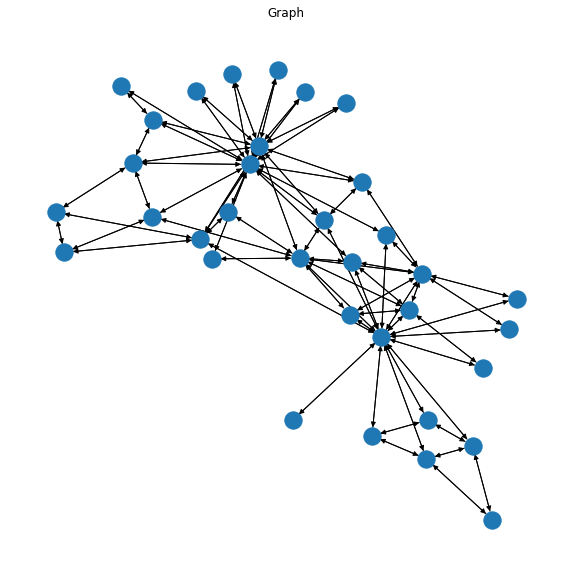

In [9]:
ax = plt.figure(figsize=(10, 10)).gca()
nx.draw(moj_graph_dla_tupla, ax=ax)
ax.set_title("Graph")


In [10]:
graphs_tuple = utils_np.networkxs_to_graphs_tuple([moj_graph_dla_tupla])
print_graphs_tuple(graphs_tuple)


Data contained in `GraphsTuple`'s fields:
globals:
[[0]]
nodes:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
edges:
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [

In [11]:
def plot_graphs_tuple_np(graphs_tuple):
  networkx_graphs = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
  num_graphs = len(networkx_graphs)
  _, axes = plt.subplots(1, num_graphs, figsize=(10, 10))
  if num_graphs == 1:
    axes = axes,
  for graph, ax in zip(networkx_graphs, axes):
    plot_graph_networkx(graph, ax)


def plot_graph_networkx(graph, ax, pos=None):
  node_labels = {node: "{:.3g}".format(data["features"][0])
                 for node, data in graph.nodes(data=True)
                 if data["features"] is not None}
  edge_labels = {(sender, receiver): "{:.3g}".format(data["features"][0])
                 for sender, receiver, data in graph.edges(data=True)
                 if data["features"] is not None}
  global_label = ("{:.3g}".format(graph.graph["features"][0])
                  if graph.graph["features"] is not None else None)

  if pos is None:
    pos = nx.spring_layout(graph)
  nx.draw_networkx(graph, pos, ax=ax, labels=node_labels)

  if edge_labels:
    nx.draw_networkx_edge_labels(graph, pos, edge_labels, ax=ax)

  if global_label:
    plt.text(0.05, 0.95, global_label, transform=ax.transAxes)

  ax.yaxis.set_visible(False)
  ax.xaxis.set_visible(False)
  return pos


def plot_compare_graphs(graphs_tuples, labels):
  pos = None
  num_graphs = len(graphs_tuples)
  _, axes = plt.subplots(1, num_graphs, figsize=(10, 10))
  if num_graphs == 1:
    axes = axes,
  pos = None
  for name, graphs_tuple, ax in zip(labels, graphs_tuples, axes):
    graph = utils_np.graphs_tuple_to_networkxs(graphs_tuple)[0]
    pos = plot_graph_networkx(graph, ax, pos=pos)
    ax.set_title(name)

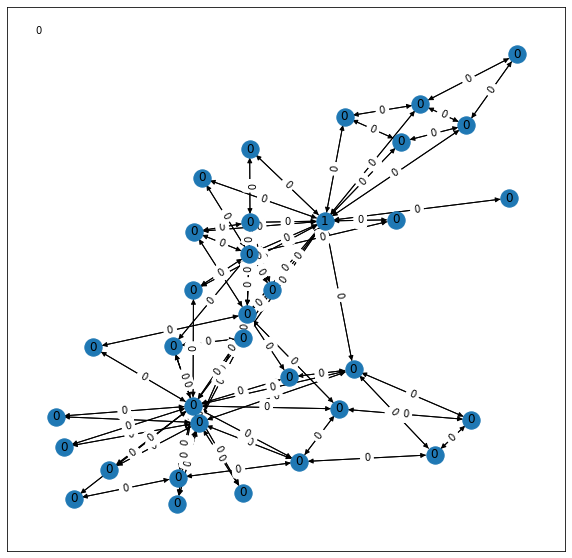

In [12]:
plot_graphs_tuple_np(graphs_tuple)

In [16]:
graph_net_module = gn.modules.RelationNetwork(
    edge_model_fn=lambda: snt.nets.MLP([0, 0]),
    node_model_fn=lambda: snt.nets.MLP([34, 2]),
    global_model_fn=lambda: snt.nets.MLP([0, 0]))

# Pass the input graphs to the graph network, and return the output graphs.
output_graphs = graph_net_module(graphs_tuple)

TypeError: __init__() got an unexpected keyword argument 'node_model_fn'

In [ ]:
graphs_tuple

In [17]:
OUTPUT_EDGE_SIZE = 10
OUTPUT_NODE_SIZE = 11
OUTPUT_GLOBAL_SIZE = 12
graph_network = modules.GraphNetwork(
    edge_model_fn=lambda: snt.Linear(output_size=OUTPUT_EDGE_SIZE),
    node_model_fn=lambda: snt.Linear(output_size=OUTPUT_NODE_SIZE),
    global_model_fn=lambda: snt.Linear(output_size=OUTPUT_GLOBAL_SIZE))
output_graphs = graph_network(graphs_tuple)

InvalidArgumentError: cannot compute ConcatV2 as input #3(zero-based) was expected to be a float tensor but is a int64 tensor [Op:ConcatV2] name: concat